In [8]:
import qiskit
print("qiskit version:", qiskit.__version__)

qiskit version: 1.4.0


In [40]:
from qiskit import IBMQ

#Save your IBM Quantum API token
IBMQ.save_account('a80d2cab0d6db0c274e192f348e18e6c40499d0f97008669e43bfb5db60e9084815b9cd4c8f06740e565a04e6e5a0fc09c39566a8fd79abe309f4ad77bedf432')

ImportError: cannot import name 'IBMQ' from 'qiskit' (c:\venv\Lib\site-packages\qiskit\__init__.py)

In [40]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
import numpy as np

# Function to create phase oracle
def phase_oracle(n, indices_to_mark, name='Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

# Optimization: using a dictionary to save created diffusers
diffuser_dict = {}
def diffuser(n):
    if n not in diffuser_dict:
        qc = QuantumCircuit(n, name='Diffuser')
        qc.h(range(n))
        qc.append(phase_oracle(n, [0]), range(n))
        qc.h(range(n))
        diffuser_dict[n] = qc
    return diffuser_dict[n]

# Grover's Algorithm Circuit
def Grover(n, indices_to_mark, r):
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    qc_oracle = phase_oracle(n, indices_to_mark)
    qc_diffuser = diffuser(n)
    for _ in range(r):
        qc.append(qc_oracle, range(n))
        qc.append(qc_diffuser, range(n))
    qc.measure(range(n), range(n))
    return qc

# Simulating Grover's Algorithm
def run_grover(n, indices_to_mark, r, shots=1024):
    sim = AerSimulator()
    sampler = SamplerV2()
    grover_circuit = Grover(n, indices_to_mark, r)
    grover_circuit = transpile(grover_circuit, sim, optimization_level=0)
    job = sampler.run([(grover_circuit, [])], shots=shots)  # Fixed incorrect sampler input format
    result = job.result()
    print(f"Grover's Algorithm Output: {result[0].data.c.get_counts()}")

# Example: Finding marked states in a 3-qubit system
run_grover(n=3, indices_to_mark=[2], r=1, shots=1024)

Grover's Algorithm Output: {'010': 797, '101': 35, '100': 30, '111': 37, '000': 29, '110': 39, '001': 30, '011': 27}


In [26]:
import numpy as np
import time
import pandas as pd
import openpyxl
import os
from qiskit import QuantumCircuit, transpile

from Noise import QiskitNoiseModelDepol,QiskitNoiseModelBitflip, QiskitNoiseModelAmplitudeDamp
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator
from qiskit.utils.parallel import parallel_map
from qiskit_aer.noise import NoiseModel

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

#
# Helper functions
#
def groverSuboptimalIterations(n, k):
    return int(np.round(0.58278 * np.sqrt(n / k)))

# r is the number of grover iterations, m is the number of marked items, n is the size of the database
def grover_success_prob(r, m, n):
    return np.sin((2 * r + 1) * np.arcsin(np.sqrt(m / n))) ** 2 * 100

# n is the size of the database, m is the number of marked items
def grover_iterations(m, n):
    #return int(np.round(np.pi *(np.sqrt(n)/4)))
    
    return int(np.round(np.pi / (4 * np.arcsin(np.sqrt(m / n))) - 1 / 2))

# selects n unique random numbers from in the range [0 - upper_bound)
def select_random_elements(upper_bound, n):
    elements = list(range(upper_bound))
    selected = []
    for i in range(n):
        index = np.random.randint(len(elements))
        selected.append(elements[index])
        del elements[index]
    return selected

# Checks if the integer representetion of binary_string exists in number_list
def binary_string_in_list(number_list, binary_string):
    num = int(binary_string, 2)
    return num in number_list

#
# Grover implementation
#

def phase_oracle(n, indicies_to_mark, name='Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indicies_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc


# Dynamic programming optimization of diffuser function
# dict to save dicts that have been computed 
diffuser_dict = {}

def diffuser(n):
    if n not in diffuser_dict:
        qc = QuantumCircuit(n, name='Diffuser')
        qc.h(range(n))
        qc.append(phase_oracle(n, [0]), range(n))
        qc.h(range(n))
        diffuser_dict.update({n: qc})
    return diffuser_dict.get(n)


def Grover(n, marked, r):
    qc = QuantumCircuit(n, n)

    qc.h(range(n))
    qc_phase = phase_oracle(n, marked)
    for _ in range(r):
        qc.append(qc_phase, range(n)) # <--- ORACLE CALL
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

#
# Functions to run experiments
#

# Runs noiseless experiment with n qubits
def simulator_experiment(n):
    start = time.time()
    backend = AerSimulator()
    
    nums = range(1, 2**n + 1)

    # runs experiment in parallel
    results = parallel_map(experiment_parallel, nums, task_args=(
        n, backend), task_kwargs={}, num_processes=4)

    end = time.time()
    
    with open(f"./noiseless_experiment_{n}qubits.txt", "a") as f:
        print("*---------------", file=f)
        print(f"Results for {n} qubits. time = {end - start} seconds\n", file=f)
        
        print("actual probabilities:\n[", end="", file=f)
        for result in results:
            print(result[0], end=", ", file=f)
        print("]\n", file=f)

        print("expected probabilities:\n[", end="", file=f)
        for result in results:
            print(result[1], end=", ", file=f)
        print("]", file=f)
        print("*---------------\n", file=f)
        

# helper function to parallelize simulator_experiment
# nums - how many marked items should be selected
# n - number of qubits
# backend - backend for the simulator
def experiment_parallel(nums, n, backend):
    print(f"started job {nums}")

    iterations = grover_iterations(nums, 2**n)
    expected_success_probability = grover_success_prob(iterations, nums, 2**n)
    iterations_per_marked_item_set = 10
    shots = 10 

    hits = 0
    
    for j in range(iterations_per_marked_item_set):
        marked = select_random_elements(2**n, nums)

        qc = Grover(n, marked, iterations)
        t_qc = transpile(qc, backend)
        result = backend.run(t_qc, shots=shots, memory=True).result()
        counts = result.get_memory()

        for count in counts:
            found_correct_element = binary_string_in_list(marked, count)
            if found_correct_element:
                hits += 1
        print(f">>> Job {nums} finished iteration {j + 1} / {iterations_per_marked_item_set}")
        
    return (((hits / (iterations_per_marked_item_set * shots)) * 100), expected_success_probability)

def simulator_experiment_noise(n, noise_level):
    start = time.time()

    nums = range(1, int(np.floor((2**n) / 2))+  1)

    results = parallel_map(experiment_parallel_noise, nums, task_args=([n, noise_level]), task_kwargs={}, num_processes=4)

    end = time.time()


    # Extract only actual probabilities
    actual_probs = [result[0] for result in results]

    # Define Excel filename
    excel_filename = f"./noise_experiment_{n}qubits.xlsx"
    
    # Check if file exists
    if os.path.exists(excel_filename):
        # Load existing data
        df = pd.read_excel(excel_filename, engine="openpyxl")
        # Add new column for current experiment
        df.loc[:,f"{noise_level} noise level"] = actual_probs
    else:
        # Create new DataFrame if file doesn't exist
        df = pd.DataFrame({
            "Number of Marked Items": nums,
            f"{noise_level} noise level": actual_probs
        })
    
    # Save to Excel
    df.to_excel(excel_filename, index=False, engine="openpyxl")
    print(f"✅ Results saved to {excel_filename} (Appended new column '{n} Qubits')")

def experiment_parallel_noise(nums, n, noise_level):
    print(f"started job {nums}")

    # how many grover iterations should be performed
    iterations = grover_iterations(nums, 2**n)
    expected_success_probability = grover_success_prob(iterations, nums, 2**n)
    
    #fake_backend = FakeAthensV2()
    #noise_model = NoiseModel.from_backend(fake_backend)


    noise_instance = QiskitNoiseModelAmplitudeDamp(noise_level)
    #noise_instance = QiskitNoiseModelBitflip(single_qubit_error=0.01)
    #noise_instance = QiskitNoiseModelDepol(single_qubit_error=0.01)

    noise_model = noise_instance.get_noise_model()
    sim= AerSimulator(noise_model=noise_model)
    #im=AerSimulator.from_backend(fake_backend)

    iterations_per_marked_item_set = 10
    shots = 10

    hits = 0
    for j in range(iterations_per_marked_item_set):

        marked = select_random_elements(2**n, nums)
        qc = Grover(n, marked, iterations)
        t_qc = transpile(qc, sim)

        result = sim.run(t_qc, shots=shots, memory=True).result()
        counts = result.get_memory()
        for count in counts:
            found_correct_element = binary_string_in_list(marked, count)
            if found_correct_element:
                hits += 1
        print(f">>> Job {nums} finished iteration {j + 1} / {iterations_per_marked_item_set}")

    return ( ((hits / (iterations_per_marked_item_set * shots)) * 100), expected_success_probability)

#simulator_experiment(4)
simulator_experiment_noise(3, 0.01*40)
#for j in range(1, 10):
 #   for i in range(0, 5):
  #      simulator_experiment_noise(j, 0.01*i)


started job 1
>>> Job 1 finished iteration 1 / 10
>>> Job 1 finished iteration 2 / 10
>>> Job 1 finished iteration 3 / 10
>>> Job 1 finished iteration 4 / 10
>>> Job 1 finished iteration 5 / 10
>>> Job 1 finished iteration 6 / 10
>>> Job 1 finished iteration 7 / 10
>>> Job 1 finished iteration 8 / 10
>>> Job 1 finished iteration 9 / 10
>>> Job 1 finished iteration 10 / 10
started job 2
>>> Job 2 finished iteration 1 / 10
>>> Job 2 finished iteration 2 / 10
>>> Job 2 finished iteration 3 / 10
>>> Job 2 finished iteration 4 / 10
>>> Job 2 finished iteration 5 / 10
>>> Job 2 finished iteration 6 / 10
>>> Job 2 finished iteration 7 / 10
>>> Job 2 finished iteration 8 / 10
>>> Job 2 finished iteration 9 / 10
>>> Job 2 finished iteration 10 / 10
started job 3
>>> Job 3 finished iteration 1 / 10
>>> Job 3 finished iteration 2 / 10
>>> Job 3 finished iteration 3 / 10
>>> Job 3 finished iteration 4 / 10
>>> Job 3 finished iteration 5 / 10
>>> Job 3 finished iteration 6 / 10
>>> Job 3 finished i

In [72]:

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2
from qiskit_aer.noise import NoiseModel

# Load the Fake Athens V2 backend
fake_backend = FakeAthensV2()
noise_model = NoiseModel.from_backend(fake_backend)


# Get the error rates from the noise model

# Get single-qubit and two-qubit gate errors
# Extract single-qubit and two-qubit errors from the noise model
print("Single-Qubit Error Rates:")
for gate, error in noise_model._single_qubit_errors.items():
    print(f"{gate}: {error}")

print("\nTwo-Qubit Error Rates:")
for gate, error in noise_model._two_qubit_errors.items():
    print(f"{gate}: {error}")

Single-Qubit Error Rates:


AttributeError: 'NoiseModel' object has no attribute '_single_qubit_errors'

In [12]:
from qiskit.providers.fake_provider import *

# List all available fake backends
print([name for name in dir() if name.startswith('Fake')])

['Fake127QPulseV1', 'Fake1Q', 'Fake20QV1', 'Fake27QPulseV1', 'Fake5QV1', 'Fake7QPulseV1', 'FakeBackend', 'FakeNoise', 'FakeOpenPulse2Q', 'FakeOpenPulse3Q', 'FakePulseBackend', 'FakeQasmBackend']


In [26]:
import qiskit
import qiskit_aer

print(qiskit.__version__)  # Should print 1.4.1
print(qiskit_aer.__version__)  # Should print a compatible version (e.g., 0.16.4)

1.4.2
0.16.4


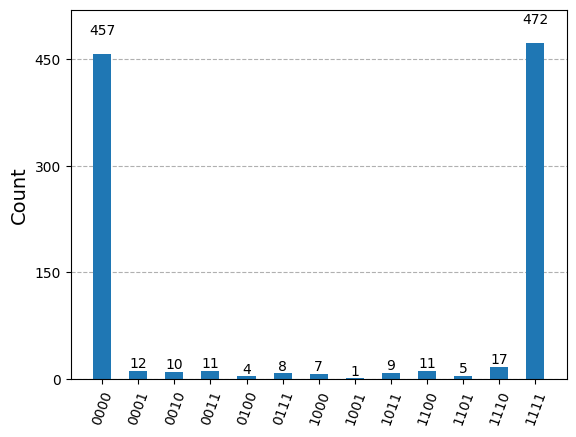

In [ ]:
import qiskit
from Noise import QiskitNoiseModel  # Import the noise model class

# Import necessary Qiskit modules
import qiskit_aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

# Create an instance of the noise model with realistic error rates
noise_instance = QiskitNoiseModel(single_qubit_error=0.02, two_qubit_error=0.05)

# Get the noise model for simulations
noise_model = noise_instance.get_noise_model()

# Define a quantum circuit with 4 qubits
circ = QuantumCircuit(4, 4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure([0, 1, 2, 3], [0, 1, 2, 3])

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model)  # No need for basis_gates
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()

# Get and visualize results
counts = result.get_counts()
plot_histogram(counts)
